In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

In [25]:
df = pd.read_csv('../src/data.csv', delimiter=';')

In [26]:
df_genre = df.assign(genres=df['genres'].str.split(',')).explode('genres')

In [27]:
df_directors = df.assign(directors=df['directors'].str.split(',')).explode('directors')

Movies per year

Text(0.5, 0, 'Year')

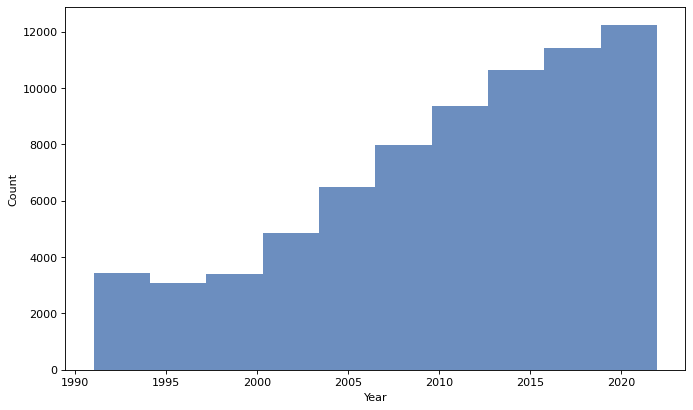

In [28]:
plt.figure(figsize=(10, 6), dpi=80)
plt.hist(df['startYear'], color='#6C8EBF')  
plt.ylabel('Count')
plt.xlabel('Year')


Movies per genre

Text(0.5, 0, 'Genre')

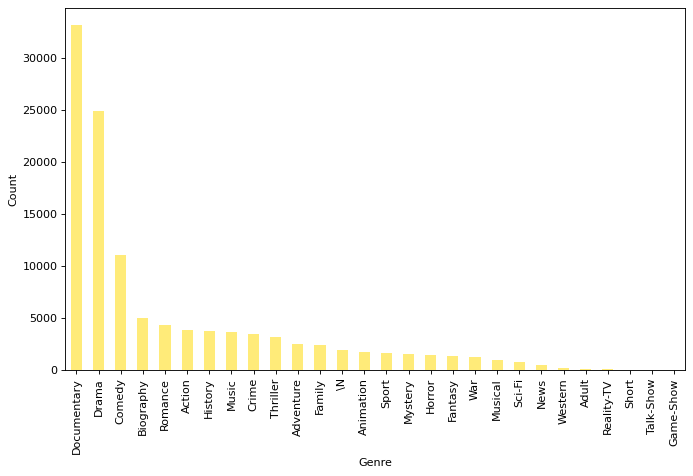

In [29]:
plt.figure(figsize=(10, 6), dpi=80)
plt.xticks(rotation=90)
df_genre['genres'].value_counts().plot.bar(color='#FFEB79')

plt.ylabel('Count')
plt.xlabel('Genre')

Text(0.5, 0, 'Adult movies')

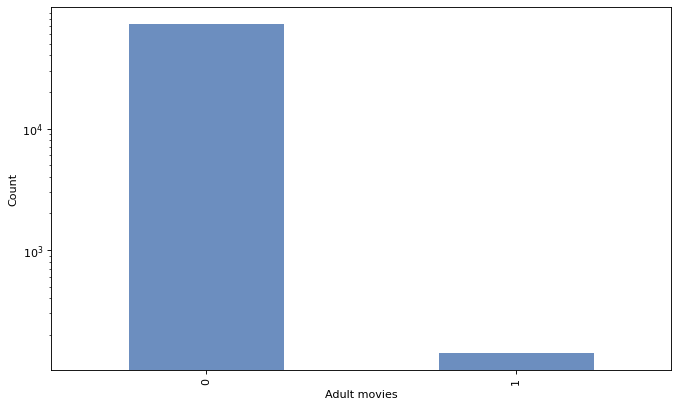

In [30]:
plt.figure(figsize=(10, 6), dpi=80)
df['isAdult'].value_counts().plot.bar(color='#6C8EBF')

plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('Adult movies')

Text(0.5, 0, 'Average Rating')

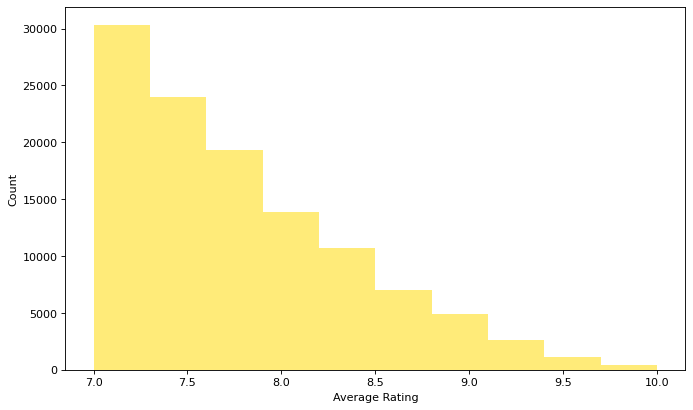

In [31]:
plt.figure(figsize=(10, 6), dpi=80)
plt.hist(df_genre['averageRating'], color='#FFEB79')  
plt.ylabel('Count')
plt.xlabel('Average Rating')

<AxesSubplot:title={'center':'averageRating'}, xlabel='genres'>

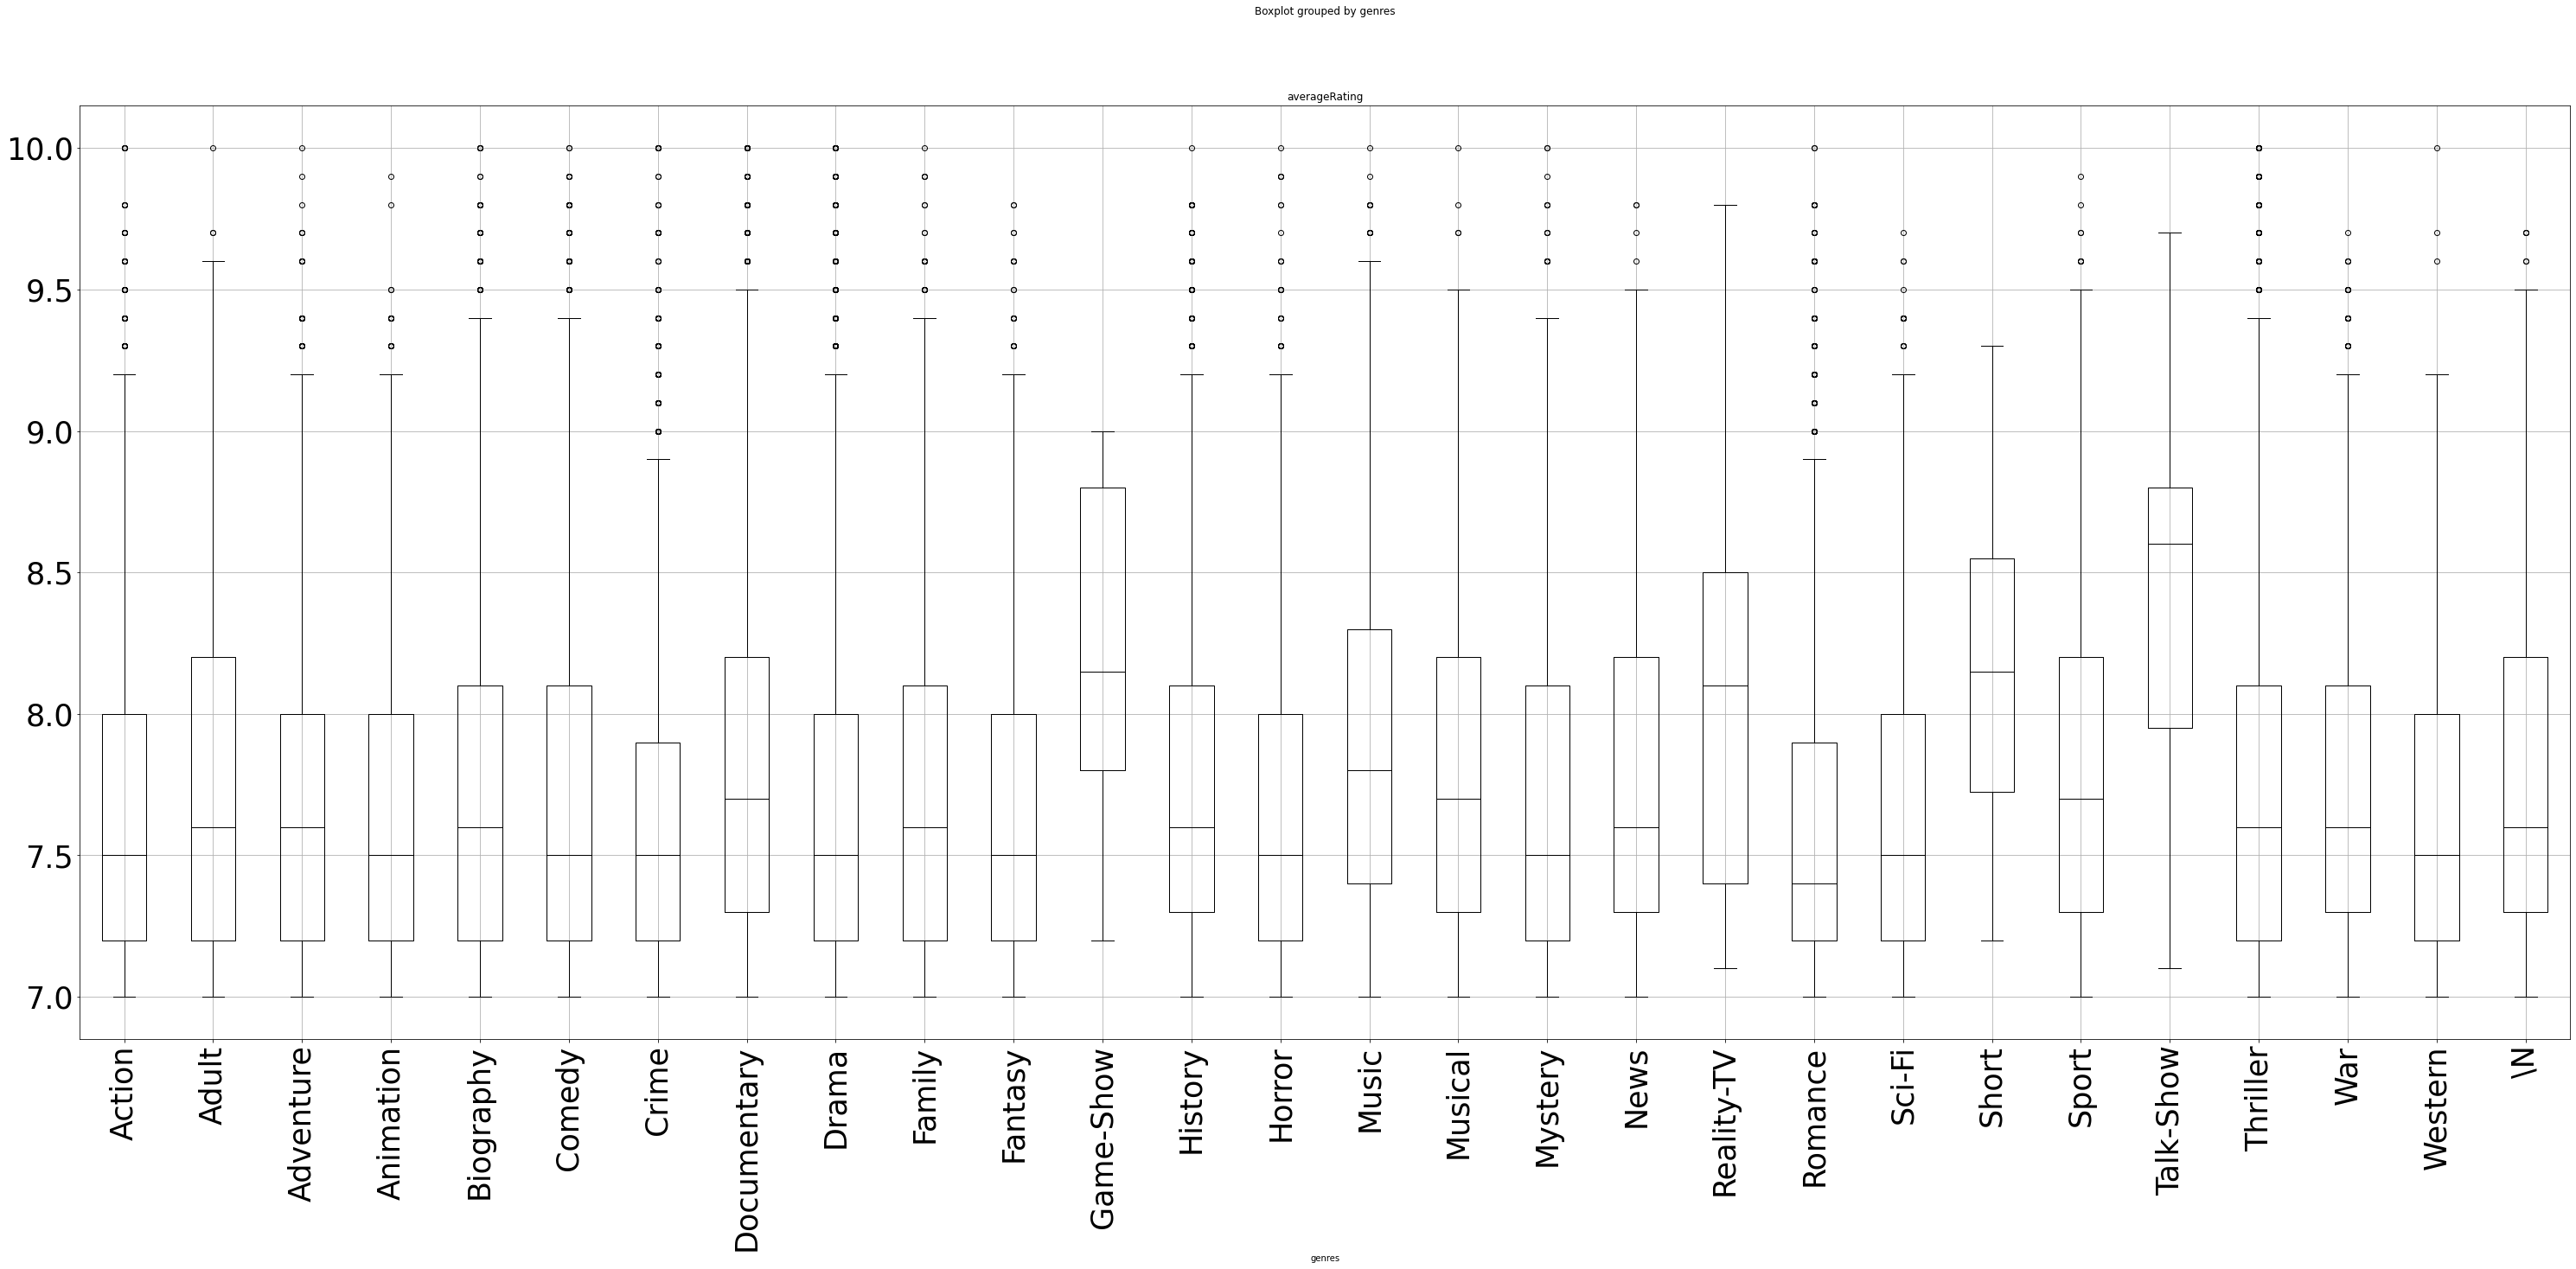

In [32]:
df_genre.boxplot(column='averageRating', by='genres', figsize=(50,20), color='black', fontsize='35', rot='vertical')

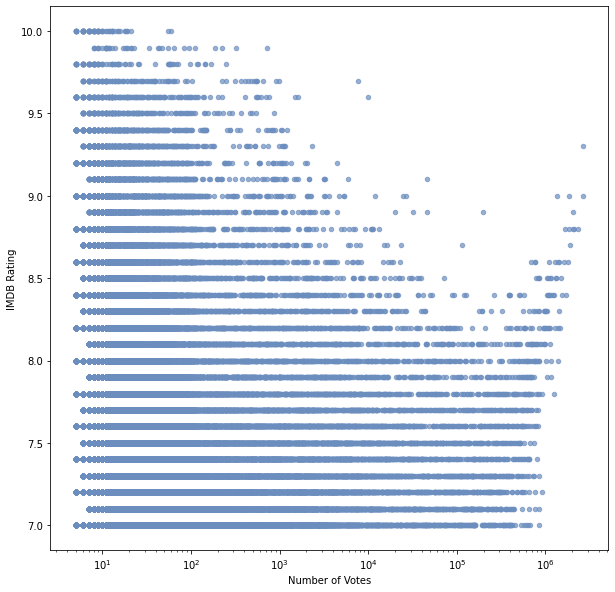

In [33]:

df.plot(kind='scatter', x='numVotes', y='averageRating', logx=True, alpha=0.7, color=['#6C8EBF'], figsize=(10,10))
plt.ylabel('IMDB Rating')
plt.xlabel('Number of Votes')
plt.show()

In [34]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')
                    

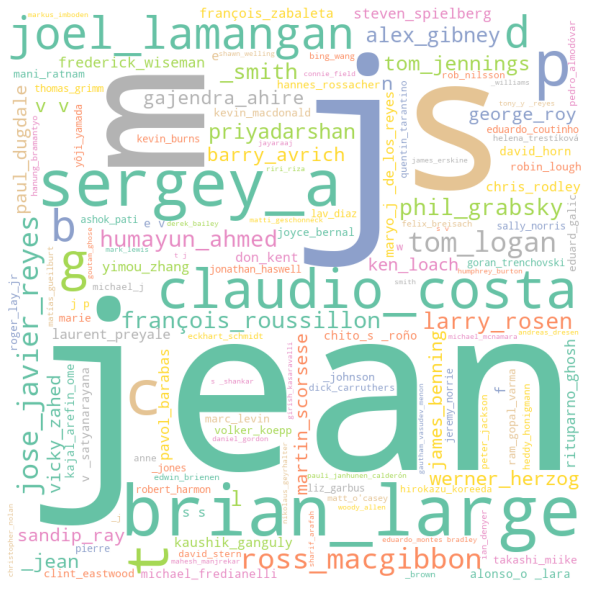

In [35]:
df_directors['directors'] = df_directors['directors'].apply(lambda x: '_'.join(str(x).split(' ')))
df_directors = df_directors[df_directors['directors'] != 'nan']

comment_words = ''

for index, row in df_directors.iterrows():
    val = str(row['directors'])
    tokens = val.split()
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(comment_words)
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

In [36]:
def return_text(df):
    comment_words = ''

    for index, row in df.iterrows():
        val = str(row['synopsis'])

        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "  
    return comment_words


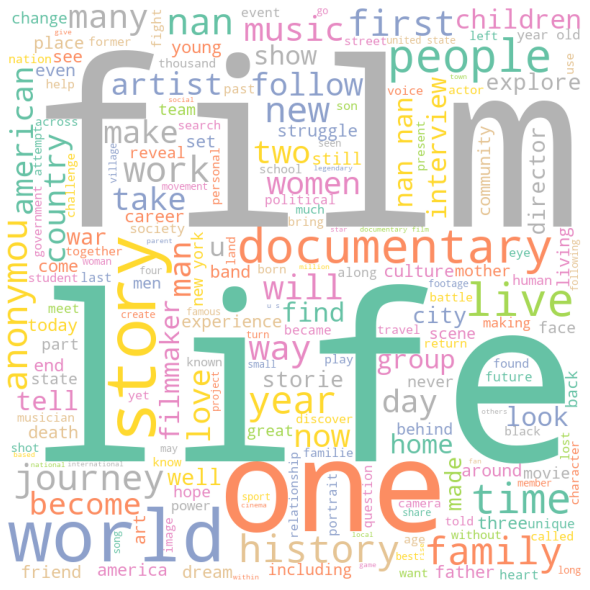

In [37]:
documentary = df_genre[df_genre['genres'] == 'Documentary']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(documentary))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

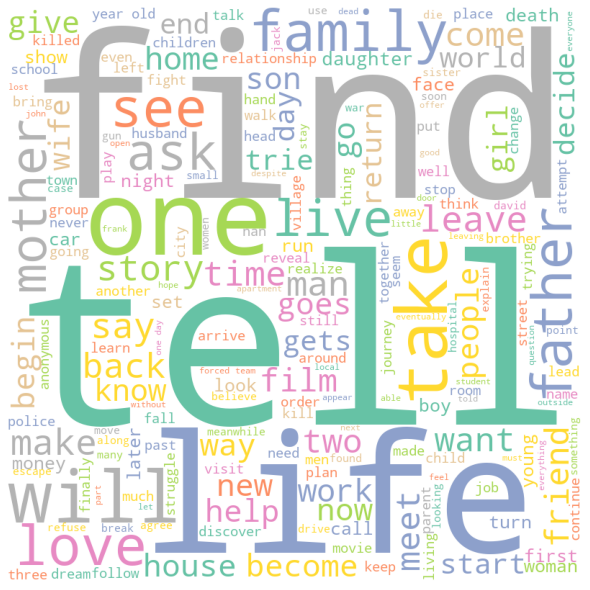

In [38]:
drama = df_genre[df_genre['genres'] == 'Drama']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(drama))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

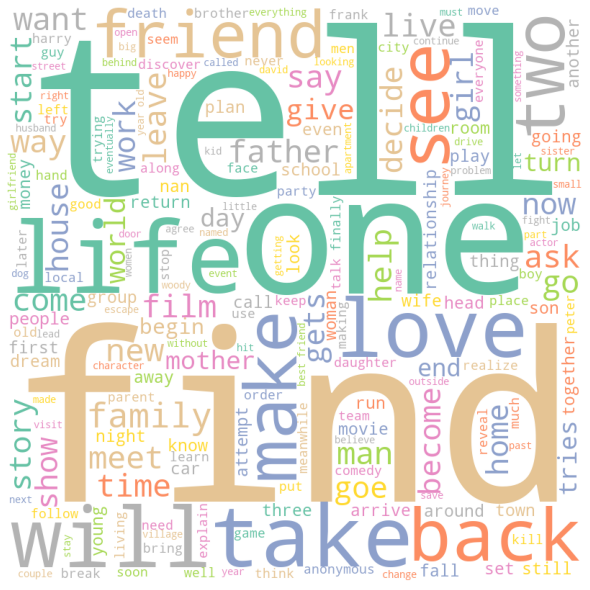

In [39]:
comedy = df_genre[df_genre['genres'] == 'Comedy']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(comedy))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()



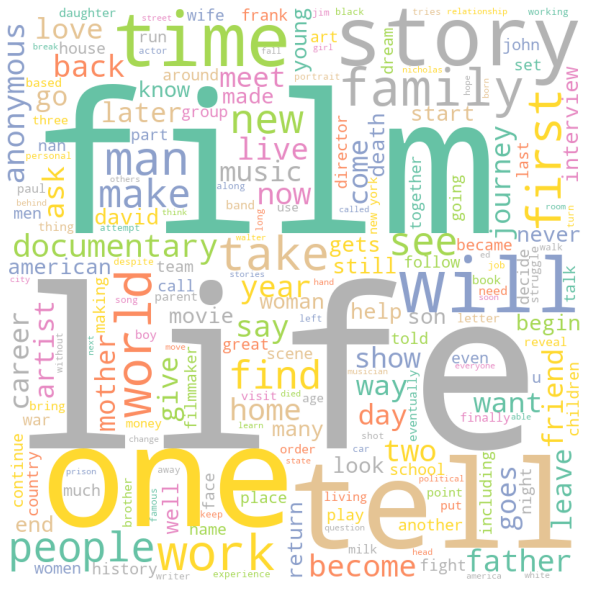

In [40]:
biography = df_genre[df_genre['genres'] == 'Biography']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(biography))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

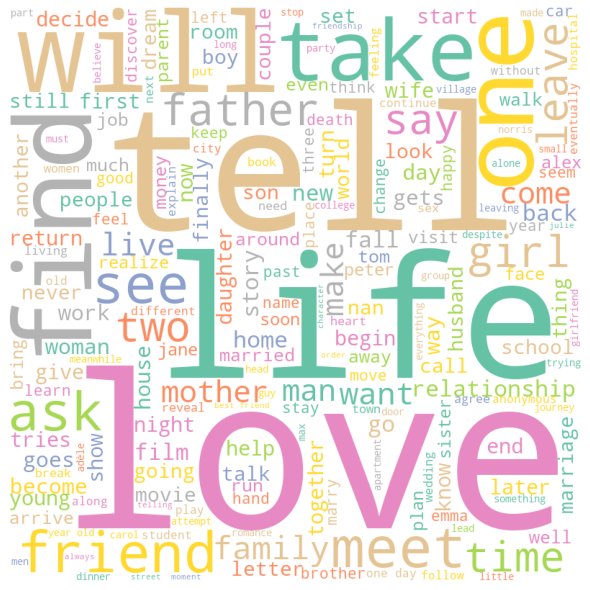

In [41]:
romance = df_genre[df_genre['genres'] == 'Romance']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(romance))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

In [42]:
import spacy
from spacy.cli import download
from spacy import displacy

download("en_core_web_sm")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [56]:
NER = spacy.load("en_core_web_sm")


biography_1 = NER(return_text(biography.head(1)))
displacy.render(biography_1, style="ent")


In [44]:
romance_1 = NER(return_text(romance.head(1)))
displacy.render(romance_1, style="ent")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/displacy/__init__.py:205: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [60]:
from keybert import KeyBERT

kw_model = KeyBERT(model='all-mpnet-base-v2')

keywords = kw_model.extract_keywords(return_text(biography.head(1)), 

                                     keyphrase_ngram_range=(1, 4), 

                                     stop_words='english', 

                                     highlight=True,

                                     top_n=10)

keywords_list= list(dict(keywords).keys())

print(keywords_list)

docu drama that follows manoel de oliveira life during the the times of dictatorship in portugal

['drama follows manoel oliveira', 'follows manoel oliveira life', 'oliveira life times dictatorship', 'life times dictatorship portugal', 'manoel oliveira life', 'docu drama follows manoel', 'oliveira life', 'times dictatorship portugal', 'dictatorship portugal', 'manoel oliveira life times']
